In [263]:
from bitarray import bitarray
from math import log2, ceil, log, e
from random_generator import bernoulli, randint
from hashes import bitarray_hash, generate_hashes
import matplotlib.pyplot as plt

In [264]:
class BloomFilter:
    container = None
    n_hashes = 1
    added = 0
    capacity = 0
    types = None
    hash_transforms = []
    N = 0

    def __init__(self, expected_n_elements, desired_fpp, work_load=.95, types='numerical'):
        """
        Initializes Bloom Filter
        :param expected_n_elements:
        :param desired_fpp:
        :param work_load: determines occupied space in filter
        :param types: types supported by the filter. Possible values ['numerical','string']
        """

        # Calculate the capacity of the filter, i.e. the total number of
        # elements that can fit.
#         capacity = ceil((log2(e) * log2(desired_fpp**-1)) * expected_n_elements / work_load)
        capacity = ceil(expected_n_elements / work_load)
#         print('cap=', capacity)

        # Calculate the number of bits required to store one element
        bpe = ceil(log2(e) * log2(desired_fpp**-1))
        s_complexity = bpe
#         self.aux_bpe = ((log2(e) * log2(desired_fpp**-1)) * expected_n_elements / work_load)/(log2(e) * log2(desired_fpp**-1))

        # Calculate the number of hashes that minimizes FPP for given
        # number of bits per entry
        self.N = ceil((log2(e) * log2(desired_fpp**-1)) * expected_n_elements / work_load)
        n_hashes = ceil(log(2) * self.N / expected_n_elements)
#         print('n_hashes =', n_hashes)

        self.n_hashes = n_hashes
        self.capacity = capacity
        self.hash_transforms = generate_hashes(n_hashes, types)

#         self.container = bitarray(s_complexity) - originally
        self.container = bitarray(self.N)
        self.container.setall(0)

    def add(self, item):
        """
        Adds an element or a list of elements in the filter. Do not check
        whether the list is longer than filter capacity.
        :param item: item or list of items to add
        :return: None
        """
        # create behavior similar to set()
        if isinstance(item, list):
            for i in item:
                self.add_item(i)
        else:
            self.add_item(item)

    def add_item(self, item):
        """
        Adding an item to the filter
        :param item:
        :return: None
        """
        # use the set of hash transforms self.hash_transforms
        # to calculate item hashes.
        # Obtain the keys from range [0, filter size]
        # using operator '%'

        # %%% ADD YOUR CODE %%%
        for h_func in self.hash_transforms:
            self.container[h_func(item) % self.N] = '1'
#             print(h_func(item) % self.capacity)
#         print(self.container)
        # %%%%%%

        if self.added < self.capacity:
            self.added += 1

    def __contains__(self, item):
        """
        Perform a membership test
        :param item:
        :return: membership test result
        """
        # use the set of hash transforms self.hash_transforms
        # to calculate item hashes.
        # Obtain the keys from range [0, filter size]
        # using operator '%'

        # %%% ADD YOUR CODE %%%
        res = True
#         print(self.container)
        for h_func in self.hash_transforms:
            if self.container[h_func(item) % self.N] == 0:
                res = False
                break
        # %%%%%%

        return res

    def current_fpp(self):
        """
        Calculate the current probability of false positives based on
        the number of currently added elements and the filter capacity
        :return: probability of false positives
        """

        # %%% ADD YOUR CODE %%%
        FPP = (1-(1-self.N**-1)**(self.added*self.n_hashes))**self.n_hashes
        # %%%%%%

        return FPP


In [258]:
class CuckooFilter:
    fingerprint_size = 0
    key_size = 0
    bucket_size = 0
    added = 0
    capacity = 0
    _hashes = None

    def __init__(self, expected_n_elements, desired_fpp, work_load=0.95, s_bucket=1, types='numerical'):
        """
        Initialize Cuckoo Filter
        :param expected_n_elements:
        :param desired_fpp:
        :param work_load: determines occupied space in filter
        :param s_bucket: number of cells in the bucket
        :param types: types supported by the filter. Possible values ['numerical','string']
        """
        self._hashes = generate_hashes(2, types)

        # Calculate the size of the fingerprint in bits
        s_fingerprint = ceil(log2(desired_fpp**-1) + log2(2*s_bucket))

        # Calculate the capacity of the filter, i.e. the total number of
        # elements that can fit.
        capacity = ceil(expected_n_elements / work_load)
        # Calculate the size of the filter in bits
        bit_size = capacity * s_fingerprint
        # Calculate the number of buckets
        n_buckets = int(capacity / s_bucket)

        self.key_size = n_buckets
        self.bucket_size = s_bucket
        self.fingerprint_size = s_fingerprint
        self.capacity = capacity

        self.container = bitarray(bit_size)
        self.container.setall(0)

    def add(self, item):
        """
        Adds an element or a list of elements in the filter. Do not check
        whether the list is longer than filter capacity.
        :param item: item or list of items to add
        :return: None
        """
        # make use of method add_item(...)
        if isinstance(item, list):
            for i in item:
                self.add_item(i)
        else:
            self.add_item(item)

    def add_item(self, item):
        """
        Adding an item to the filter
        :param item:
        :return: None
        """
        # Make use of methods _fingerprint, _get_keys, _try_set, _relocate

        # %%% ADD YOUR CODE %%%
        
        
        fp = self._fingerprint(item)
        keys = self._get_keys(item, fp)

        if self._try_set(keys[0], fp) or self._try_set(keys[1], fp):
            pass
        else:
            self._relocate(keys, fp)
        
        # %%%%%%

        if self.added < self.capacity:
            self.added += 1

    def __contains__(self, item):
        """
        Perform a membership test
        :param item:
        :return: membership test result
        """

        # Hint: Make note of how method _try_set works
        # %%% ADD YOUR CODE %%%
        fp = self._fingerprint(item)
        keys = self._get_keys(item, fp)
        
        
        bpe = self.fingerprint_size
        # Convert key to bitarray index
        for key in keys:
            index = self._get_index(key)
            for b in range(self.bucket_size):
                pos_of_interest = index + b * bpe
                # if cell is empty, overwrite
                if self.container[pos_of_interest: pos_of_interest + bpe] == fp:
                    return True
        # %%%%%%
        return False

    # Service functions
    def _fingerprint(self, item):
        combinations = 2 ** self.fingerprint_size
        hashf = self._hashes[0]
        fp = hashf(item) % combinations
        # related to question 10: zero value prohibition.
        if int(fp) == 0:
            fp += 1
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        return self.to_bits(fp)


    def _hash(self, val):
        hashf = self._hashes[1]
        h = hashf(val)
        return h

    def to_bits(self, hash_value):
        temp = bitarray()
        temp.frombytes((hash_value).to_bytes(8, 'big'))
        return temp[-self.fingerprint_size:]

    def _get_index(self, key):
        return key * self.bucket_size * self.fingerprint_size

    def current_fpp(self):
        """
        Calculate the current probability of false positives based on
        the current number of added elements and the filter capacity
        :return: probability of false positives
        """
        # %%% ADD YOUR CODE %%%
        fp_size = self.fingerprint_size
        b = self.bucket_size
        l = self.added / self.capacity
        final_power = 2*b*l
        fpp = 1-(1-2**-fp_size)**final_power
        # %%%%%%
        return fpp

    def _get_keys(self, item, fingerprint):
        """
        Calculate bucket keys for input item
        :param item:
        :param fingerprint:
        :return: shuffled keys
        """
        key_size = self.key_size
        _hash = self._hash

#         i1 = _hash(item) % key_size - previous
        i1 = int(_hash(item) % key_size)
        i2 = (bitarray_hash(fingerprint) ^ i1) % key_size
        

        keys = [i1, i2] if bernoulli() else [i2, i1]
        return keys

    def _try_set(self, key, fingerprint):
        """
        Try write fingerprint to some cell in a bucket. Return False of
        the bucket is full
        :param key:
        :param fingerprint:
        :return: success status
        """
        bpe = self.fingerprint_size
        # Convert key to bitarray index
        index = self._get_index(key)
        for b in range(self.bucket_size):
            pos_of_interest = index + b * bpe
            # if cell is empty, overwrite
            if self.container[pos_of_interest: pos_of_interest + bpe].count() == 0:
                self.container[pos_of_interest: pos_of_interest + bpe] = fingerprint
                return True
        return False

    def _relocate(self, keys, fingerprint):
        """
        Rewrite the value of a random cell from a random bucket
        The overwritten element is lost
        :param keys:
        :param fingerprint:
        :return: None
        """
        bpe = self.fingerprint_size
        b_size = self.bucket_size

        key_ind = bernoulli()
        bucket_ind = randint(b_size)

        index = self._get_index(keys[key_ind])
        pos_of_interest = index + bucket_ind * bpe

        # for the sake of simplisity, the existing value is not reassigned

        self.container[pos_of_interest: pos_of_interest + bpe] = fingerprint

In [224]:
cf = CuckooFilter(expected_n_elements=10, desired_fpp=.05)

In [250]:
cf.add_item(5)
cf.add_item(7)
cf.add_item(2)
cf.add_item(23)
cf.add_item(25)
cf.add_item(26)
cf.add_item(26)
cf.__contains__(8)
print(cf.current_fpp())

0.031005859375


In [243]:
cf = CuckooFilter(expected_n_elements=10, desired_fpp=.05)
assert 1 not in cf
cf.add(1)
assert cf.key_size == 11
assert cf.fingerprint_size == 6
assert 1 in cf

In [ ]:
from numpy.random import randint
from numpy import array, random
import matplotlib.pyplot as plt

random.seed(1)

In [ ]:
expected = 30
d_FPP = .01
trials = 100
elements_to_add = int(expected * 1.3)
added_elements = set()

In [255]:
CuckooFilter(expected_n_elements=10, desired_fpp=.01).fingerprint_size

8

In [256]:
import numpy as np

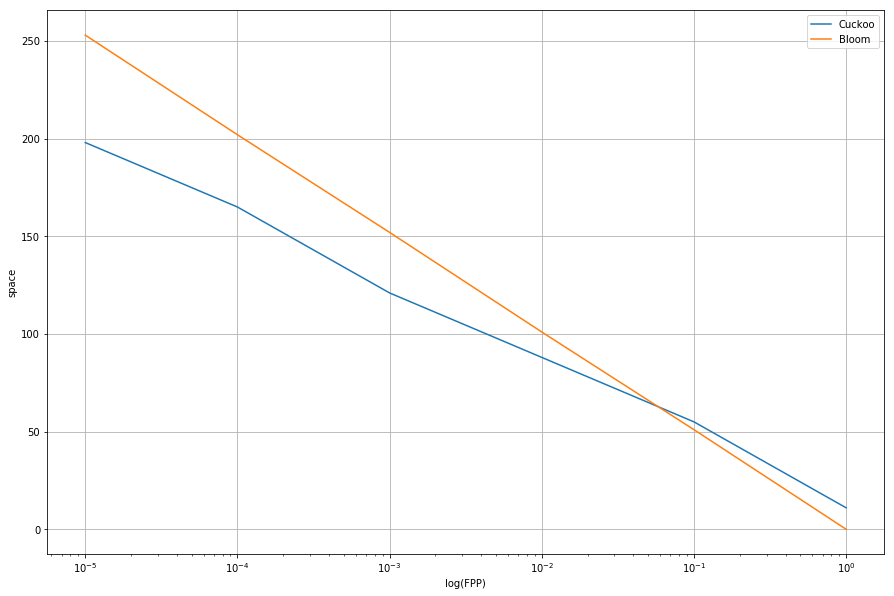

In [269]:
plt.figure(figsize=[15,10])
cf_sizes = []
bf_sizes = []
for fpp in np.geomspace(1e-5, 1, 6):
    cf = CuckooFilter(expected_n_elements=10, desired_fpp=fpp)
    size = cf.capacity * cf.fingerprint_size
    cf_sizes += [size,]
    
    bf = BloomFilter(expected_n_elements=10, desired_fpp=fpp)
    size = bf.N 
    bf_sizes += [size,]
plt.semilogx(np.geomspace(1e-5, 1, 6), cf_sizes, label='Cuckoo')
plt.semilogx(np.geomspace(1e-5, 1, 6), bf_sizes, label='Bloom')
plt.grid()
plt.xlabel('log(FPP)')
plt.ylabel('space')
plt.legend()
plt.show()